In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
 
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])
 

	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

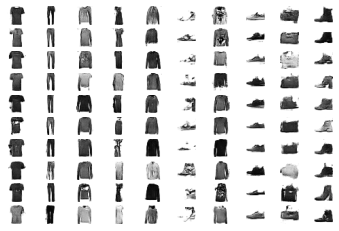

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = g_model
# generate images
latent_points, labels = generate_latent_points(100, 2000)
# specify labels
labels = asarray([x for _ in range(200) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# converting images to csv

x= X
print(x.shape)
x= np.reshape(x,(x.shape[0],-1))
# print(x)



df = pd.DataFrame(x)
df.shape
# df.to_csv('CGAN_images_2000.csv', header= None, index = None)

(2000, 28, 28, 1)


(2000, 784)

(2000, 784)
The new shape of file is :  (2000, 28, 28, 1)


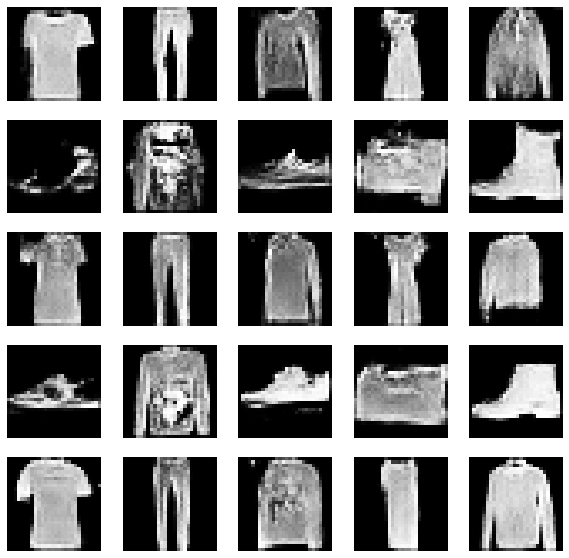

In [ ]:
def load_fake_images():
  df = pd.read_csv('CGAN_images_2000.csv', sep = ',', header = None)
  df= np.array(df)
  print(df.shape)
  fake_imgs =  np.reshape(df, (-1,28,28,1))
  # print(df.max(), df.min(), sep=' ')
  # plt.imshow(df[4,:,:,0])
  print("The new shape of file is : ", fake_imgs.shape)

  # fig = plt.figure(figsize=(10, 10))
  # for i in range(25):
  #     plt.subplot(5, 5, i+1)
  #     plt.imshow(fake_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  #     plt.axis('off')

  return fake_imgs 


cgan_images= load_fake_images()
cgan_images= cgan_images[0:1000,:]


In [ ]:
(trainX, trainy), (_, _) = load_data()

trainX = trainX.astype('float32')
# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5


trainX= trainX-1
trainX= trainX[0:1000,:]

trainX = np.reshape(trainX,(-1,28,28,1))
print(trainX.shape)
print(cgan_images.shape)
 



(1000, 28, 28, 1)
(1000, 28, 28, 1)


In [ ]:
from numpy import mean, std
from math import floor
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.models import Sequential, load_model
# from keras.optimizers import SGD
from tensorflow.keras.layers import MaxPooling2D,Activation,Flatten,Dropout,Dense,Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets.mnist import load_data

from numpy.random import randint
import pandas as pd




from numpy import cov , iscomplexobj , trace
from numpy.random import random
from scipy.linalg import sqrtm

import random

In [ ]:
def FIDs_distance(real , fake):
    
    model = load_model('FID_classifier.h5')
    model.pop()
    model.pop()
    model.pop()
    # model.pop()

    # model.summary()
    
    real = model.predict(real)
    fake = model.predict(fake)
    
    # Computing mean
    mean1 = np.mean(real , axis = 0)
    mean2 = np.mean(fake , axis = 0)
    
    # computing variance
    
    var1 = np.cov(real, rowvar = False) # rowvar = false , we need to take the variance along the column 
    var2 = np.cov(fake, rowvar = False)
#     computing difference of mean 

    mean_sq = np.sum((mean1- mean2)**2.0)
    meanvar = sqrtm(np.dot(var1 , var2))
    
    if np.iscomplexobj(meanvar):
        meanvar = meanvar.real
        
    FIDs = mean_sq + trace(var1 + var2 - 2.0 * meanvar)
    
    return FIDs

In [ ]:
fid_score = FIDs_distance(trainX, cgan_images)
print("------------------------------------------------------------ ")
print("Ferchet Inception Distance Between Real and Generated Images")
print("------------------------------------------------------------\n")

print("-------------------")
print('FIDs =  %.5f' % fid_score)
print("-------------------\n")


fid_score = FIDs_distance(trainX, trainX)
print("------------------------------------------------------------ ")
print("Ferchet Inception Distance Between Real ")
print("------------------------------------------------------------\n")

print("-------------------")
print('FIDs =  %.5f' % fid_score)
print("-------------------\n")


------------------------------------------------------------ 
Ferchet Inception Distance Between Real and Generated Images
------------------------------------------------------------

-------------------
FIDs =  587.12690
-------------------

------------------------------------------------------------ 
Ferchet Inception Distance Between Real 
------------------------------------------------------------

-------------------
FIDs =  -0.00000
-------------------



In [ ]:
def IS_score (images):
    model = load_model('FID_classifier.h5')
    pyx = model.predict(images)
    # print(p_yx.shape)
    # calculate p(y)
    py = np.expand_dims(pyx.mean(axis=0), 0)
    # calculate KL divergence using log probabilities
    kLdiv = pyx * (np.log(pyx) - np.log(py))
    # sum over classes
    kLdiv_sum = kLdiv.sum(axis=1)
    # average over images
    AvgKL = mean(kLdiv_sum)
    # undo the log
    is_score = np.exp(AvgKL)
    # print(is_score)
    # store
    # scores.append(is_score)
    is_score = np.array(is_score) 
    # print(is_score)

    return is_score




# print("------------------------------")
# print("Score on Real Image")
# print("------------------------------")

# RIS_score  = IS_score(trainX)
# print(RIS_score)


print("\n------------------------------")
print("Score on Fafke Image")
print("------------------------------")
FIS_score = IS_score(cgan_images)
print(FIS_score)



------------------------------
Score on Fafke Image
------------------------------
6.915082
